In [1]:
import pandas as pd
import numpy as np
import nltk

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM, CuDNNLSTM, Flatten
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag, pos_tag_sents
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')

lemmatizer = WordNetLemmatizer()

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renatapva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renatapva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/renatapva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/renatapva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/renatapva/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
# import pre-processed files
twitter = pd.read_csv("twitter_pre_processed.csv");
wiki = pd.read_csv("wiki_pre_processed.csv");

# merging datasets
data = pd.concat([twitter, wiki]);

# remove stop words
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]));

# stemming
stemmer = SnowballStemmer('english')
data['text'] = data['text'].apply(stemmer.stem)

# apply POS tags to DF
textList = data['text'].tolist();
tagged_texts = pos_tag_sents(map(word_tokenize, textList));
data['POS'] = tagged_texts;

# use sentiword to check positivity/negativity of sentences
sentiment = 0.0;
data['sentiment'] = 0;

for index, row in data.iterrows():
    sentiment = 0.0
    for word, tag in row['POS']:
        wnTag = None;
        
        # transform POS tags into sentiwordnet tags
        if tag.startswith('J'):
            wnTag = wn.ADJ;
        elif tag.startswith('N'):
            wnTag = wn.NOUN;
        elif tag.startswith('R'):
            wnTag = wn.ADV;
        elif tag.startswith('V'):
            wnTag = wn.VERB;
        
        if wnTag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
            continue;
            
        lemma = lemmatizer.lemmatize(word, pos=wnTag)
        if not lemma:
            continue;
            
        synsets = wn.synsets(lemma, pos=wnTag)
        if not synsets:
            continue

        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
    
    if(sentiment>=0):
        data.loc[data.index==index, 'sentiment'] = 1
    else:
        data.loc[data.index==index, 'sentiment'] = 0
        
# separate train and test datasets
y = data['class'];
X = data[['text', 'sentiment']];
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# vectorizer
vectorizer = CountVectorizer(analyzer = 'word', max_features = 1999)
X_train_vec = vectorizer.fit_transform(list(X_train.text))
X_test_vec = vectorizer.transform(list(X_test.text))

X_train_sent = np.array(X_train.sentiment)
X_train_sent = np.reshape(X_train_sent, (X_train_sent.shape[0], 1))
X_train_vec_np = np.array(X_train_vec.todense())
X_train_final = np.concatenate((X_train_vec_np, X_train_sent),axis=1)

X_test_sent = np.array(X_test.sentiment)
X_test_sent = np.reshape(X_test_sent, (X_test_sent.shape[0], 1))
X_test_vec_np = np.array(X_test_vec.todense())
X_test_final = np.concatenate((X_test_vec_np, X_test_sent),axis=1)

# creating dictionary
X_train_final = np.array(X_train_final)
X_test_final = np.array(X_test_final)

X_train_final = np.reshape(X_train_final, (X_train_final.shape[0], 1, X_train_final.shape[1]))
X_test_final = np.reshape(X_test_final, (X_test_final.shape[0], 1, X_test_final.shape[1]))

In [3]:
# define network architecture and compile 
model = Sequential()
model.add(CuDNNLSTM(100, input_shape=(1,2000))) 
model.add(Dense(250, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [4]:
# train model
history = model.fit(X_train_final, y_train, epochs=5, verbose=2, validation_split=0.1)

Train on 132817 samples, validate on 14758 samples
Epoch 1/5
 - 21s - loss: 0.1882 - acc: 0.9360 - val_loss: 0.1757 - val_acc: 0.9423
Epoch 2/5
 - 19s - loss: 0.1561 - acc: 0.9454 - val_loss: 0.1650 - val_acc: 0.9436
Epoch 3/5
 - 19s - loss: 0.1387 - acc: 0.9510 - val_loss: 0.1671 - val_acc: 0.9444
Epoch 4/5
 - 19s - loss: 0.1195 - acc: 0.9577 - val_loss: 0.1777 - val_acc: 0.9441
Epoch 5/5
 - 19s - loss: 0.0988 - acc: 0.9647 - val_loss: 0.2025 - val_acc: 0.9413


In [5]:
# check score
score = model.evaluate(X_test_final, y_test)
print(score)

36894/36894 [==============================] - 2s 55us/step
[0.20805661295635394, 0.93944814875370541]


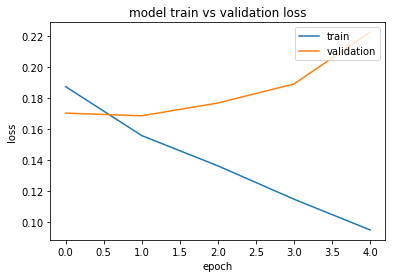

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [7]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_final)
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     33522
         1.0       0.72      0.56      0.63      3372

   micro avg       0.94      0.94      0.94     36894
   macro avg       0.84      0.77      0.80     36894
weighted avg       0.93      0.94      0.94     36894

